In [1]:
import os
import glob
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from IPython import display

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 6GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], 
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    except RuntimeError as e:
        print(e)

In [3]:
PATH_1 = '../datasets/Anime_Sketch_Colorization_Pair'
train_path_1 = os.path.join(PATH_1, 'train')
test_path_1 = os.path.join(PATH_1, 'test')
print(train_path_1, test_path_1)

../datasets/Anime_Sketch_Colorization_Pair\train ../datasets/Anime_Sketch_Colorization_Pair\test


In [4]:
PATH_2 = '../datasets/auto painter sketch-only-sub'
train_path_2 = os.path.join(PATH_2, 'train')
test_path_2 = os.path.join(PATH_2, 'test')
print(train_path_2, test_path_2)

../datasets/auto painter sketch-only-sub\train ../datasets/auto painter sketch-only-sub\test


In [5]:
train_data = glob.glob(train_path_1 + '/*.png')
test_data = glob.glob(test_path_1 + '/*.png')
train_data += glob.glob(train_path_2 + '/*.png')
test_data += glob.glob(test_path_2 + '/*.png')

In [6]:
BUFFER_SIZE = 512
BATCH_SIZE = 4
IMG_WIDTH = 512
IMG_HEIGHT = 512
OUTPUT_CHANNELS = 3

In [7]:
def normalize(sketch, colored):
    sketch = (sketch / 127.5) - 1
    colored = (colored / 127.5) - 1
    
    return sketch, colored

In [8]:
def denormalize(image):
    image = (image + 1) * 127.5
    image = image.numpy()
    
    return image.astype(np.uint8)

In [9]:
@tf.function
def load_image(image_file, position=0):
    # The position is 0 if the sketch image is left and 1 if the sketch image is right.
    image = tf.io.read_file(image_file)
    image = tf.image.decode_image(image, expand_animations=False)
    
    w = tf.shape(image)[1]
    
    w = w // 2
    
    left_image = image[:, :w, :]
    right_image = image[:, w:, :]
    
    left_image = tf.cast(left_image, tf.float32)
    right_image = tf.cast(right_image, tf.float32)
    
    if position == 0:
        return left_image, right_image
    else:
        return right_image, left_image

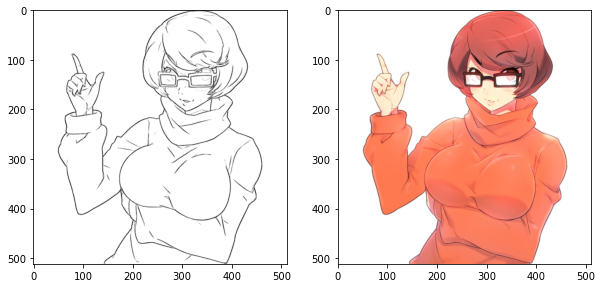

In [10]:
sketch, colored = load_image(train_data[0], position=1)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(sketch / 255.0)
plt.subplot(1, 2, 2)
plt.imshow(colored / 255.0)

In [11]:
def resize(sketch, colored, height=512, width=512):
    sketch = tf.image.resize(sketch, [height, width], method=tf.image.ResizeMethod.BICUBIC)
    colored = tf.image.resize(colored, [height, width], method=tf.image.ResizeMethod.BICUBIC)
    
    return sketch, colored

In [12]:
@tf.function
def augmentation(sketch, colored):
    # resizing to 512 x 512 x 3
    sketch, colored = resize(sketch, colored)
    
    if tf.random.uniform(()) > 0.5:
        # random flip
        sketch = tf.image.flip_left_right(sketch)
        colored = tf.image.flip_left_right(colored)
    
    return sketch, colored

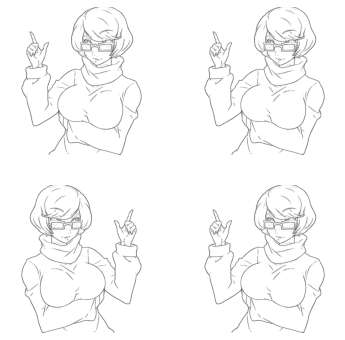

In [13]:
plt.figure(figsize=(6, 6))
for i in range(4):
    sketch_aug, colored_aug = augmentation(sketch, colored)
    plt.subplot(2, 2, i+1)
    plt.imshow(sketch_aug / 255.0)
    plt.axis('off')
plt.show()

In [14]:
def load_image_train(image_file, position=1):
    sketch, colored = load_image(image_file, position)
    sketch, colored = augmentation(sketch, colored)
    sketch, colored = normalize(sketch, colored)
    
    return sketch, colored

In [15]:
def load_image_test(image_file, position=1):
    sketch, colored = load_image(image_file, position)
    sketch, colored = resize(sketch, colored, IMG_HEIGHT, IMG_WIDTH)
    sketch, colored = normalize(sketch, colored)
    
    return sketch, colored

In [16]:
train_dataset = tf.data.Dataset.list_files(train_data)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [17]:
test_dataset = tf.data.Dataset.list_files(test_data)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 512, 512, 3)
(4, 512, 512, 3)


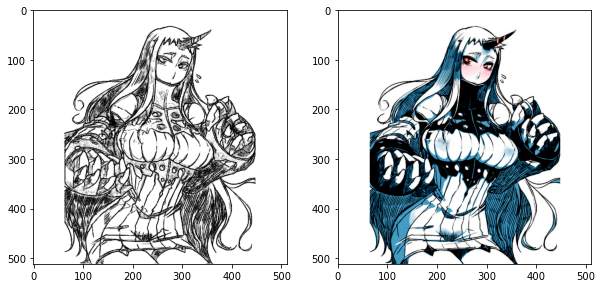

In [18]:
for i, j in test_dataset.take(1):
    print(i.shape)
    print(j.shape)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(i[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(j[0]))

In [19]:
def downsample(filters, size, apply_bn=True, alpha=0.2):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2,
                                      padding='same', 
                                      kernel_initializer=initializer, 
                                      use_bias=False))
    
    if apply_bn:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha))
    
    return result

In [20]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(sketch, 0))
print(down_result.shape)

(1, 256, 256, 3)


In [21]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, 
                                               padding='same', 
                                               kernel_initializer=initializer,
                                               use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.ReLU())
    
    return result

In [22]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 512, 512, 3)


In [23]:
def Generator():
    inputs = tf.keras.Input(shape=[512, 512, 3])
    
    down_stack = [
        downsample(64, 4, apply_bn=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, 
                                           padding='same', 
                                           kernel_initializer=initializer, 
                                           activation='tanh')
    
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
generator = Generator()

In [25]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 256, 256, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 128, 128, 128 131584      sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 64, 64, 256)  525312      sequential_3[0][0]               
______________________________________________________________________________________________

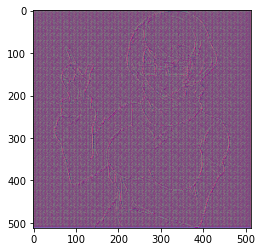

In [26]:
gen_output = generator(tf.expand_dims(sketch, axis=0), training=False)
plt.imshow(np.squeeze(gen_output) / 2 + 0.5)

In [27]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.Input(shape=[IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS], name='input_image')
    tar = tf.keras.Input(shape=[IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS], name='target_image')
    
    x = tf.keras.layers.concatenate([inp, tar], axis=3)
    
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    down4 = downsample(512, 4)(down3)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)
    conv1 = tf.keras.layers.Conv2D(512, 4, strides=1, 
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv1)
    leaky_relu1 = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu1) # (bs, 33, 33, 512)
    conv2 = tf.keras.layers.Conv2D(1, 4, strides=1,
                                 kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    batchnorm2 = tf.keras.layers.BatchNormalization()(conv2)
    leaky_relu2 = tf.keras.layers.LeakyReLU()(batchnorm2)
    
    output = tf.keras.layers.Activation('sigmoid')(leaky_relu2)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=output)

In [28]:
discriminator = Discriminator()

In [29]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 512, 512, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_18 (Sequential)      (None, 256, 256, 64) 6144        concatenate_7[0][0]        

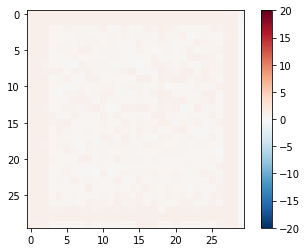

In [30]:
disc_out = discriminator([tf.expand_dims(sketch, axis=0), gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [31]:
def create_vgg_model():
    vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=[512, 512, 3])
    vgg16.trainable = False
    for l in vgg16.layers:
        l.trainable = False
    vgg_model = tf.keras.Model(inputs=vgg16.input, outputs=vgg16.get_layer('block4_conv3').output)
    vgg_model.trainable = False
    
    return vgg_model

In [32]:
vgg_model = create_vgg_model()

In [33]:
weight_G = 1
weight_p = 50
weight_f = 0.0001
weight_tv = 0.001

In [34]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [35]:
def tv_loss(image):
    loss_y = tf.reduce_mean(tf.math.square(image[:, 1:, :, :] - image[:, :-1, :, :]))
    loss_x = tf.reduce_mean(tf.math.square(image[:, :, 1:, :] - image[:, :, :-1, :]))
    loss_tv = tf.reduce_mean(tf.math.sqrt(loss_y + loss_x))
    loss_tv = tf.cast(loss_tv, tf.float32)
    
    return loss_tv

In [36]:
def generator_loss(gen_out, target, disc_gen_out, vgg_model):
    gen_loss_G = tf.reduce_mean(-tf.math.log1p(disc_gen_out))
    gen_loss_p = tf.reduce_mean(tf.abs(target - gen_out))
    gen_loss_f = tf.reduce_mean(tf.abs(vgg_model(target) - vgg_model(gen_out)))
    gen_loss_tv = tv_loss(target)
    gen_total_loss = weight_G * gen_loss_G + weight_p * gen_loss_p + weight_f * gen_loss_f + weight_tv * gen_loss_tv
    return gen_total_loss, gen_loss_p

In [37]:
def discriminator_loss(disc_gen_out, disc_tar_out):
    real_loss = bce_loss(tf.ones_like(disc_tar_out), disc_tar_out)
    fake_loss = bce_loss(tf.zeros_like(disc_gen_out), disc_gen_out)
    
    return real_loss + fake_loss

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [39]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                                 discriminator_optimizer=discriminator_optimizer, 
                                 generator=generator, 
                                 discriminator=discriminator)

In [40]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [41]:
f = test_data[30]
sample_sketch, sample_colored = load_image(f)
sample_sketch, sample_colored = normalize(sample_sketch, sample_colored)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


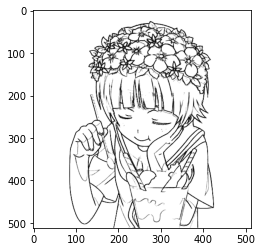

In [42]:
plt.imshow(sample_colored)

In [43]:
def generate_and_save_image(epoch):
    pred = generator(tf.expand_dims(sample_sketch, 0), training=True)
    plt.figure(figsize=(5, 5))
    plt.imshow(denormalize(pred[0]))
    plt.axis('off')
    plt.title(f'epoch : {epoch}', size=16)
    plt.savefig(f'./result_image/sample_epoch_{epoch:04d}')

In [44]:
EPOCHS = 1

In [45]:
import datetime
log_dir = "./logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [46]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_fake_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_l1_loss = generator_loss(gen_output, target, disc_fake_output, vgg_model)
        disc_loss = discriminator_loss(disc_real_output, disc_fake_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [47]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        
        display.clear_output(wait=True)
        generate_and_save_image(epoch)        
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        
        print("Epoch: ", epoch)
        
        # Train
        for n, (input_image, target) in tqdm(train_ds.enumerate()):
            train_step(input_image, target, epoch)
        
        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [48]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 21408), started 1:12:00 ago. (Use '!kill 21408' to kill it.)

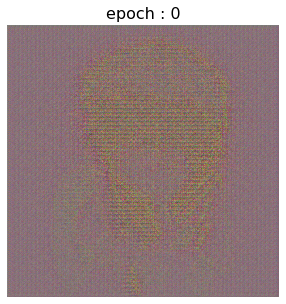

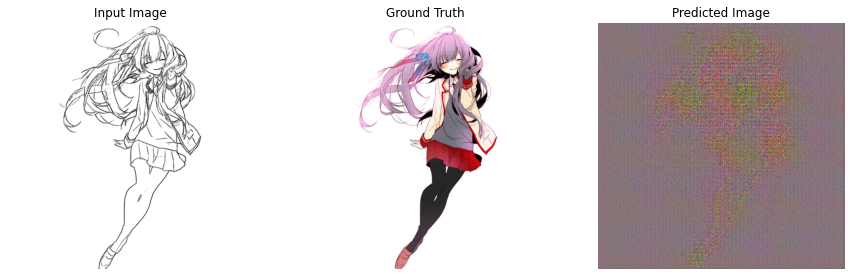

  0%|                                                                                                                                    | 0/4776 [00:00<?, ?it/s]

Epoch:  0


 39%|██████████████████████████████████████████████▊                                                                          | 1849/4776 [11:11<16:43,  2.92it/s]

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)